In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, KBinsDiscretizer
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE, SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE, ADASYN
from xgboost import XGBClassifier

In [2]:
# Load the data
data = pd.read_csv("cell2celltrain.csv")

In [3]:
# Assuming 'Churn' is labeled as 'Churn' and contains 'Yes'/'No' values
data['Churn'] = data['Churn'].map({'Yes': 1, 'No': 0}).astype(int)

In [4]:
# Data Preprocessing
data.fillna(data.mean(), inplace=True)
categorical_features = data.select_dtypes(include=['object']).columns.difference(['Churn'])
data = pd.get_dummies(data, columns=categorical_features, drop_first=True)


C:\Users\user\AppData\Local\Temp\ipykernel_14448\1618882540.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.fillna(data.mean(), inplace=True)


In [5]:
# Simplifying Feature Engineering by selectively using Polynomial Features

# Apply polynomial features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
data_poly = poly.fit_transform(data[numerical_features])
data_poly = pd.DataFrame(data_poly, columns=poly.get_feature_names_out(numerical_features))

In [6]:
# Use SelectKBest to select features that have the strongest relationship with the output variable
selector = SelectKBest(f_classif, k=20)  # You can adjust k based on feature importance or desired complexity
data_poly_selected = selector.fit_transform(data_poly, data['Churn'])
selected_features_names = data_poly.columns[selector.get_support()]

In [7]:
# Printing selected features for review
print("Selected Polynomial Features based on their correlation with the target:")
print(selected_features_names)

Selected Polynomial Features based on their correlation with the target:
Index(['TotalRecurringCharge', 'CurrentEquipmentDays', 'RetentionCalls',
       'CustomerID TotalRecurringCharge', 'CustomerID CurrentEquipmentDays',
       'CustomerID RetentionCalls', 'MonthlyRevenue CurrentEquipmentDays',
       'TotalRecurringCharge HandsetModels', 'TotalRecurringCharge AgeHH1',
       'MonthsInService CurrentEquipmentDays',
       'MonthsInService RetentionCalls', 'UniqueSubs CurrentEquipmentDays',
       'UniqueSubs RetentionCalls', 'ActiveSubs CurrentEquipmentDays',
       'ActiveSubs RetentionCalls', 'Handsets CurrentEquipmentDays',
       'HandsetModels CurrentEquipmentDays',
       'CurrentEquipmentDays RetentionCalls',
       'CurrentEquipmentDays IncomeGroup', 'AgeHH1 RetentionCalls'],
      dtype='object')


In [8]:
# Combining selected polynomial features with the original dataset
data_poly_selected = pd.DataFrame(data_poly_selected, columns=selected_features_names)
data = pd.concat([data.drop(numerical_features, axis=1), data_poly_selected], axis=1)

In [9]:
# Splitting data into features and target
X = data.drop('Churn', axis=1)
y = data['Churn']

In [10]:
# Applying ADASYN to handle class imbalance
adasyn = ADASYN(random_state=42)
X_adasyn, y_adasyn = adasyn.fit_resample(X, y)

In [11]:
# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_adasyn)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_adasyn, test_size=0.2, random_state=42)

In [12]:
# Model building
models = {
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier()
}

In [13]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [14]:
# Create an empty DataFrame to store the results
# results_df = pd.DataFrame(columns=['Model', 'Precision', 'Recall', 'F1-Score', 'Support', 'Accuracy'])

# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Model', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC','Accuracy',])

In [15]:
# Model training and evaluation
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate scores
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    # Calculate ROC-AUC
    # Ensure your model can estimate probabilities via `predict_proba`
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]  # probability estimates for the positive class
        roc_auc = roc_auc_score(y_test, y_prob)
    else:  # use decision function if predict_proba is not available
        y_scores = model.decision_function(X_test)
        roc_auc = roc_auc_score(y_test, y_scores)

    # Append results to DataFrame
    results_df = pd.concat([results_df, pd.DataFrame({
        'Model': [name],
        'Precision': [precision],
        'Recall': [recall],
        'F1-Score': [f1],
        'Accuracy': [accuracy],
        'ROC-AUC': [roc_auc]
    })], ignore_index=True)

# Save the results to an Excel file and CSV file
results_df.to_excel('Simplified_Feature_Engineering_without_Cross_validation_May11.xlsx', index=False)
results_df.to_csv('Simplified_Feature_Engineering_without_Cross_validation_May11.csv', index=False)

C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

In [17]:
# Create an empty DataFrame to store the results
cv_results_df = pd.DataFrame(columns=['Model', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC','Accuracy'])

In [18]:
# Iterate through the models and perform cross-validation
for name, model in models.items():
    # Perform cross-validation
    cv_scores = cross_validate(model, X, y, cv=5, scoring=['precision', 'recall', 'f1', 'roc_auc','accuracy'])
    
    # Calculate average scores
    precision = np.mean(cv_scores['test_precision'])
    recall = np.mean(cv_scores['test_recall'])
    f1 = np.mean(cv_scores['test_f1'])
    accuracy = np.mean(cv_scores['test_accuracy'])
    roc_auc = np.mean(cv_scores['test_roc_auc'])
    
    # Print the results
    print(f"Results for {name}:")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")
    print(f"ROC-AUC: {roc_auc}")
    print(f"Accuracy: {accuracy}")
    print("-" * 50)
    
    # Save the results to the DataFrame
    cv_results_df = cv_results_df.append({
        'Model': name,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'Accuracy': accuracy
    }, ignore_index=True)

# Display the results in the notebook
print(cv_results_df)

# Save the DataFrame to a CSV file
cv_results_df.to_csv('Simplified_Featuring_Engineering_With_Cross_validation_May11.csv', index=False)

# Save the results to an Excel file
cv_results_df.to_excel('Simplified_Featuring_Engineering_With_Cross_validation_May11.xlsx', index=False)

Results for Decision Tree:
Precision: 0.28706300614182434
Recall: 0.305753111520891
F1-Score: 0.2894028545480783
ROC-AUC: 0.49610357154693496
Accuracy: 0.5767424779023406
--------------------------------------------------


C:\Users\user\AppData\Local\Temp\ipykernel_14448\1822190010.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cv_results_df = cv_results_df.append({


Results for Random Forest:
Precision: 0.3519734316595285
Recall: 0.07382321668926925
F1-Score: 0.11479340897593557
ROC-AUC: 0.567456862760515
Accuracy: 0.6874442506175295
--------------------------------------------------


C:\Users\user\AppData\Local\Temp\ipykernel_14448\1822190010.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cv_results_df = cv_results_df.append({


Results for Logistic Regression:
Precision: 0.4969793702523836
Recall: 0.01434287492264653
F1-Score: 0.027731035700542396
ROC-AUC: 0.5396126500182707
Accuracy: 0.7112465552230661
--------------------------------------------------


C:\Users\user\AppData\Local\Temp\ipykernel_14448\1822190010.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cv_results_df = cv_results_df.append({


Results for Gradient Boosting:
Precision: 0.2899054896692131
Recall: 0.028279434799370683
F1-Score: 0.047105703051389516
ROC-AUC: 0.5933209294367991
Accuracy: 0.6926942590360966
--------------------------------------------------


C:\Users\user\AppData\Local\Temp\ipykernel_14448\1822190010.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cv_results_df = cv_results_df.append({


Results for XGBoost:
Precision: 0.29482477396381346
Recall: 0.11087085626218338
F1-Score: 0.14705528489976424
ROC-AUC: 0.5385186418077643
Accuracy: 0.6507123911426504
--------------------------------------------------
                 Model  Precision    Recall  F1-Score   ROC-AUC  Accuracy
0        Decision Tree   0.287063  0.305753  0.289403  0.496104  0.576742
1        Random Forest   0.351973  0.073823  0.114793  0.567457  0.687444
2  Logistic Regression   0.496979  0.014343  0.027731  0.539613  0.711247
3    Gradient Boosting   0.289905  0.028279  0.047106  0.593321  0.692694
4              XGBoost   0.294825  0.110871  0.147055  0.538519  0.650712


C:\Users\user\AppData\Local\Temp\ipykernel_14448\1822190010.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cv_results_df = cv_results_df.append({


In [19]:
import pandas as pd

# Function to load and merge data
def load_and_merge_data():
    # Replace 'path_to_your_first_csv.csv' and 'path_to_your_second_csv.csv'
    # with the actual paths to your CSV files.
    df_without_cv = pd.read_csv('Simplified_Feature_Engineering_without_Cross_validation_May11.csv')
    df_with_cv = pd.read_csv('Simplified_Featuring_Engineering_With_Cross_validation_May11.csv')
    
    # Rename the column in df_with_cv for consistency
    df_with_cv.rename(columns={"Model": "Evaluation Metric"}, inplace=True)
    
    return df_without_cv, df_with_cv

# Function to write data to an Excel file
def write_to_excel(df_without_cv, df_with_cv):
    # Create a Pandas Excel writer using XlsxWriter as the engine
    with pd.ExcelWriter('Simplified_Feature_Engineering_Merged_results_May11.xlsx', engine='xlsxwriter') as writer:
        # Write each dataframe to a different worksheet with custom header
        df_without_cv.to_excel(writer, sheet_name='Without Cross Validation', startrow=1, index=False)
        worksheet1 = writer.sheets['Without Cross Validation']
        worksheet1.write('A1', 'Model Performance without Cross Validation')

        df_with_cv.to_excel(writer, sheet_name='With Cross Validation', startrow=1, index=False)
        worksheet2 = writer.sheets['With Cross Validation']
        worksheet2.write('A1', 'Model Performance with Cross Validation')

# Main function to orchestrate the operations
def main():
    df_without_cv, df_with_cv = load_and_merge_data()
    write_to_excel(df_without_cv, df_with_cv)
    print("Excel file has been created successfully.")

# Execute the main function
main()

Excel file has been created successfully.


In [20]:
print(results_df)

                 Model  Precision    Recall  F1-Score   ROC-AUC  Accuracy
0        Decision Tree   0.713119  0.696166  0.704541  0.707103  0.707067
1        Random Forest   0.849122  0.677477  0.753650  0.848739  0.777801
2  Logistic Regression   0.954043  0.604782  0.740286  0.831391  0.787108
3    Gradient Boosting   0.813898  0.655078  0.725902  0.821103  0.751810
4              XGBoost   0.824402  0.672255  0.740595  0.835375  0.763737


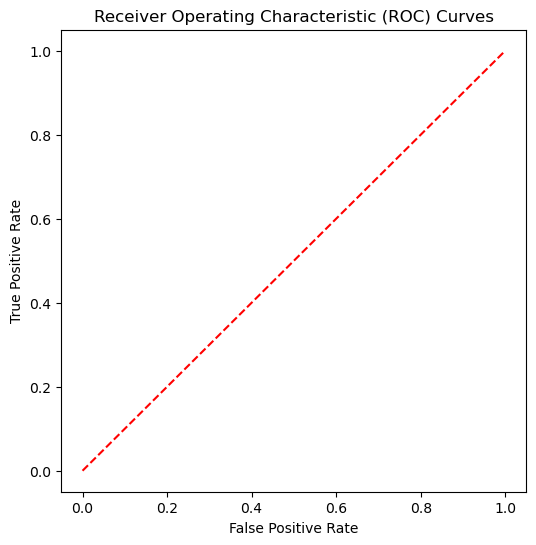

In [28]:
# Initialize plot
plt.figure(figsize=(6, 6))
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], 'r--')

C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


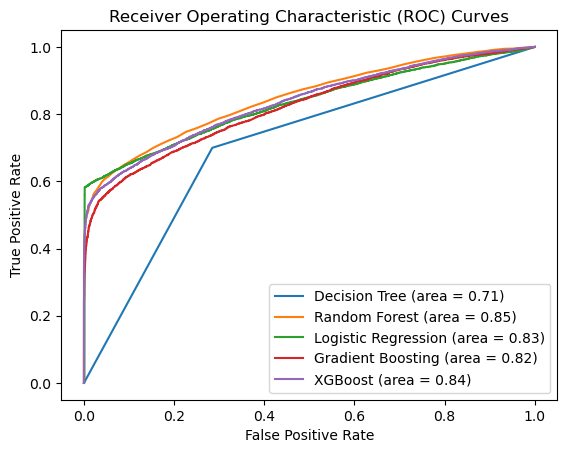

In [29]:
# Train each model and plot their ROC curves
from sklearn.metrics import roc_curve, auc

for name, model in models.items():
    model.fit(X_train, y_train)
    if hasattr(model, "predict_proba"):  # Check if model supports probability predictions
        y_prob = model.predict_proba(X_test)[:, 1]
    else:  # Use decision function if predict_proba is not available
        y_prob = model.decision_function(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (area = {roc_auc:.2f})')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()